In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
folder = '/content/gdrive/MyDrive/pytest_img/cats_dogs'
train_dir = folder+"/train"
validation_dir = folder+"/validation"
test_dir = folder+"/test"

In [11]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=100, class_mode='binary',
  classes=['cats', 'dogs'])
validation_generator = validation_datagen.flow_from_directory(
  validation_dir, target_size=(224, 224), batch_size=100, class_mode='binary',
  classes=['cats', 'dogs'])
test_generator = test_datagen.flow_from_directory(
  test_dir, target_size=(224, 224), batch_size=100, class_mode='binary',
  classes=['cats', 'dogs'])


Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [13]:
# include_top=False를 통해 최종 완전연결층을 제거하고, 가중치를 가져온다
vgg = VGG19(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

vgg.trainable = True # 우선 모든 층의 가중치를 학습이 가능한 형태로 만듦

for layer in vgg.layers[:-4]: # 마지막에서 네 번째 층까지는 가중치 동결
  layer.trainable = False

# 결과를 Flatten 하여 Dense 층에 붙일 수 있게 한다
x = Flatten()(vgg.output)

# Flatten된 결과를 Dense층에 입력하여, 분류기 형태가 되게 한다
# 이진분류이므로 출력층 노드는 1, 활성화함수는 sigmoid이다. 다중분류에서는 softmax를 사용한다
prediction = Dense(1, activation='sigmoid')(x)

# FunctionalAPI를 이용하여 모델을 구성한다
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [14]:
import tensorflow as tf
model.compile(loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
  metrics=['acc'])

In [15]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
history = model.fit(
  train_generator,
  steps_per_epoch=20,
  epochs=100,
  validation_data=validation_generator,
  validation_steps=10)

Epoch 1/100
 1/20 [>.............................] - ETA: 5:41 - loss: 0.6862 - acc: 0.6000

20/20 [==============================] - 40s 1s/step - loss: 0.6862 - acc: 0.6000 - val_loss: 10.0617 - val_acc: 0.5000


In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
print('Accuracy of each epoch:', np.round(acc))
print()
print('Validation Accuracy of each epoch:', np.round(val_acc))

Accuracy of each epoch: [1.]

Validation Accuracy of each epoch: [0.]


In [17]:
print('Loss of each epoch:', np.round(loss, 3))
print()
print('Validation Loss of each epoch:', np.round(val_loss, 3))


Loss of each epoch: [0.686]

Validation Loss of each epoch: [10.062]


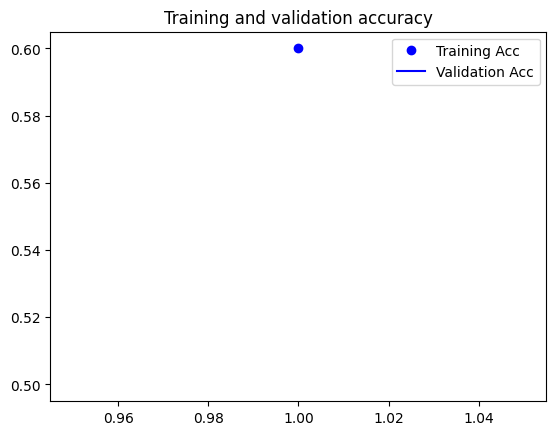

In [18]:
import matplotlib.pyplot as plt
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

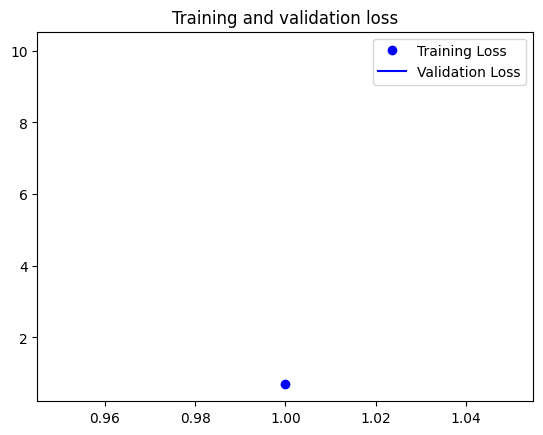

In [19]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
model.evaluate(test_generator)

1/1 [==============================] - 20s 20s/step - loss: 10.5303 - acc: 0.5000


[10.530323028564453, 0.5]